In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [3]:
s = []
prefix = "HH_object_BITP_"
for i in range(1, 9):
        s.append(open("test-object-id-all-bitp-stats-0%d.txt" % i, "r").readlines())

In [4]:
raw_pr = []
raw_mem = []
raw_time = []
for i in range(len(s)):
    ln = 0
    query_type = ""
    for line in s[i]:
        if line.startswith("Stats request at line"):
            ln = int(re.search("\d+", line).group())
        if line.find(" timers") != -1:
            query_type = line.strip().split(" ")[0]
        if line.find(" ms = ") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                sketch = [sketch[0], ''.join(sketch[1:])]
                raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
        if line.find("prec") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                sketch = [sketch[0], ''.join(sketch[1:])]
                pr_info = t[1].split(",")
                try:
                    pr_info = list(map(lambda x: eval(x.split('=')[1].strip()), pr_info))
                except ZeroDivisionError:
                    continue
                raw_pr.append(sketch + ["Precision", pr_info[0]])
                raw_pr.append(sketch + ["Recall", pr_info[1]])
        if line.find("MB") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
                raw_mem.append(t)

In [5]:
mem_df = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage"])
mem_df

,Sketch,Param,Stream Size,Memory Usage
0,PCM_HH,logU17e0.001d0.01D2000,13528042,39308532
1,TMG_BITP,e0.001000,13528042,292540088
2,SAMPLING_BITP,ss50000use_new_impl2,13528042,31420888
3,PCM_HH,logU17e0.001d0.01D2000,27056084,43088052
4,TMG_BITP,e0.001000,27056084,400775080
...,...,...,...,...
2513,SAMPLING_BITP,ss500000use_new_impl2,1352804200,229809632
2514,SAMPLING_BITP,ss500000use_new_impl2_max,1352804200,704005056
2515,PCM_HH,logU17e0.01d0.001D2000,1352804200,206689664
2516,SAMPLING_BITP,ss500000use_new_impl2,1352804200,229809856


In [6]:
time_df = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Value"])
time_df_processed = pd.merge(time_df, mem_df, on = ["Sketch", "Param", "Stream Size"]).drop_duplicates()
update_time_df = time_df_processed[time_df_processed["Type"] == "Update"]
update_time_df

,Sketch,Param,Stream Size,Type,Value,Memory Usage
0,PCM_HH,logU17e0.001d0.01D2000,13528042,Update,43558,39308532
2,TMG_BITP,e0.001000,13528042,Update,11784,292540088
4,SAMPLING_BITP,ss50000use_new_impl2,13528042,Update,5026,31420888
5,SAMPLING_BITP,ss50000use_new_impl2,13528042,Update,5026,31420896
8,SAMPLING_BITP,ss50000use_new_impl2,13528042,Update,5280,31420888
...,...,...,...,...,...,...
5130,PCM_HH,logU17e0.01d0.001D2000,1339276158,Update,6339243,202746624
5132,SAMPLING_BITP,ss500000use_new_impl2,1339276158,Update,883277,358456576
5134,PCM_HH,logU17e0.01d0.001D2000,1352804200,Update,6396116,206689664
5142,SAMPLING_BITP,ss500000use_new_impl2,1352804200,Update,893209,229809632


In [7]:
pr_df = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Metric", "Value"])
pr_df

,Sketch,Param,Metric,Value
0,PCM_HH,logU17e0.001d0.01D2000,Precision,0.924855
1,PCM_HH,logU17e0.001d0.01D2000,Recall,1.000000
2,TMG_BITP,e0.001000,Precision,0.424403
3,TMG_BITP,e0.001000,Recall,1.000000
4,SAMPLING_BITP,ss50000use_new_impl2,Precision,0.928144
...,...,...,...,...
289,SAMPLING_BITP,ss500000use_new_impl2,Recall,1.000000
290,PCM_HH,logU17e0.01d0.001D2000,Precision,0.056457
291,PCM_HH,logU17e0.01d0.001D2000,Recall,1.000000
292,SAMPLING_BITP,ss500000use_new_impl2,Precision,0.969136


In [8]:
last_mem_df = mem_df.groupby(["Sketch", "Param"]).agg({"Memory Usage": "max"})
last_mem_df

Memory Usage
Sketch        Param                                   
PCM_HH        logU17e0.0001d0.01D2000        525351380
              logU17e0.001d0.001D2000        281698780
              logU17e0.001d0.01D2000         201638580
              logU17e0.01d0.001D2000         206689664
              logU17e1e05d0.01D2000         3768773916
              logU17e2e05d0.01D2000         1966715172
              logU17e5e05d0.01D2000          885772936
              logU32e0.001d0.01D2000         272774520
SAMPLING_BITP ss1000000use_new_impl2        1325688128
              ss1000000use_new_impl2_max    1344005056
              ss100000use_new_impl2          132088800
              ss100000use_new_impl2_max      140805056
              ss2000000use_new_impl2        2650494904
              ss500000use_new_impl2          668614176
              ss500000use_new_impl2_max      704005056
              ss50000use_new_impl2            67170592
              ss50000use_new_impl2_max        70405056
TMG_BITP      e0.000100                     8095540728
              e0.000200                     5524952824
              e0.000400                     3599026792
              e0.000600                     2643755208
              e0.000800                     2031264488
              e0.001000                     1602583728

In [9]:
pr_df_processed = pd.DataFrame(pd.merge(pr_df, last_mem_df, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage", "Metric"]).mean().to_records())
pr_df_processed

,Sketch,Param,Memory Usage,Metric,Value
0,PCM_HH,logU17e0.0001d0.01D2000,525351380,Precision,0.853548
1,PCM_HH,logU17e0.0001d0.01D2000,525351380,Recall,0.981027
2,PCM_HH,logU17e0.001d0.001D2000,281698780,Precision,0.868128
3,PCM_HH,logU17e0.001d0.001D2000,281698780,Recall,0.984933
4,PCM_HH,logU17e0.001d0.01D2000,201638580,Precision,0.859133
5,PCM_HH,logU17e0.001d0.01D2000,201638580,Recall,0.989397
6,PCM_HH,logU17e0.01d0.001D2000,206689664,Precision,0.045237
7,PCM_HH,logU17e0.01d0.001D2000,206689664,Recall,0.993304
8,PCM_HH,logU17e1e05d0.01D2000,3768773916,Precision,0.826165
9,PCM_HH,logU17e1e05d0.01D2000,3768773916,Recall,0.985491


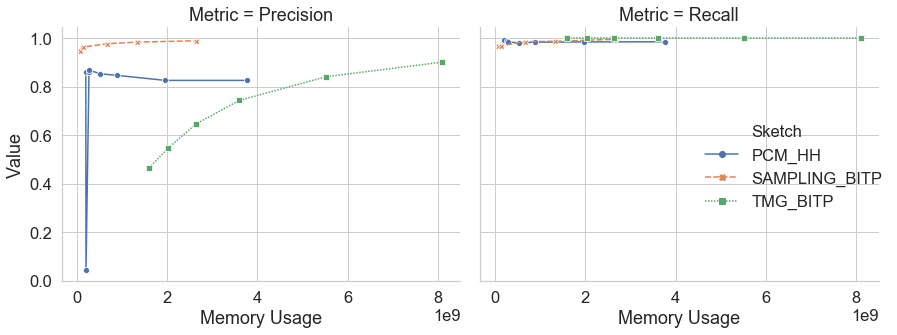

In [10]:
g = sns.relplot(x="Memory Usage", y="Value", hue="Sketch", style = "Sketch", col = "Metric", kind = "line",  markers=True,data=pr_df_processed)
plt.tight_layout()
plt.savefig(prefix + 'pr.pdf')

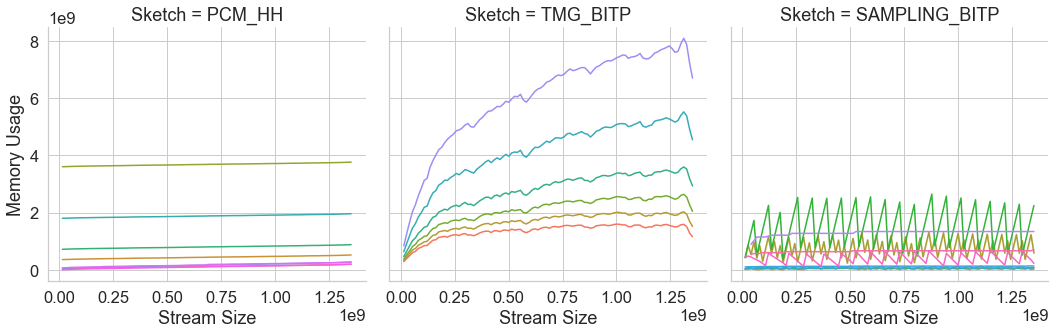

In [11]:
g = sns.relplot(x="Stream Size", y="Memory Usage", hue="Param", data=mem_df, dashes = False, col="Sketch",
                kind="line", legend=False)
plt.tight_layout()
plt.savefig(prefix + 'mem.pdf')

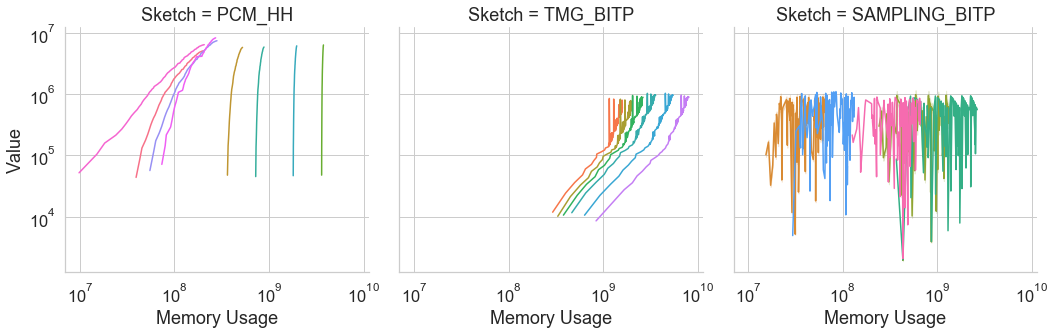

In [12]:
g = sns.relplot(x="Memory Usage", y="Value", hue="Param", style = "Param", col = "Sketch", kind = "line",  dashes = False, data=update_time_df, legend = False)
g.set(xscale = "log", yscale="log")
plt.tight_layout()
plt.savefig(prefix + 'time.pdf')